# Engaging with Multimodal Models: GPT-4V in AutoGen

In AutoGen, leveraging multimodal models can be done through two different methodologies:
1. **MultimodalAgent**: Supported by GPT-4V and other LMMs, this agent is endowed with visual cognitive abilities, allowing it to engage in interactions comparable to those of other ConversableAgents.
2. **VisionCapability**: For LLM-based agents lacking inherent visual comprehension, we introduce vision capabilities by converting images into descriptive captions.

This guide will delve into each approach, providing insights into their application and integration.

### Before everything starts, install AutoGen with the `lmm` option

Install `autogen-agentchat`:
```bash
pip install "autogen-agentchat[lmm]~=0.2"
```

For more information, please refer to the [installation guide](/docs/installation/).


In [1]:
import json
import os
import random
import time
from typing import Any, Callable, Dict, List, Optional, Tuple, Type, Union

import matplotlib.pyplot as plt
import numpy as np
import requests
from PIL import Image
from termcolor import colored

import autogen
from autogen import Agent, AssistantAgent, ConversableAgent, UserProxyAgent
from autogen.agentchat.contrib.capabilities.vision_capability import VisionCapability
from autogen.agentchat.contrib.img_utils import get_pil_image, pil_to_data_uri
from autogen.agentchat.contrib.multimodal_conversable_agent import MultimodalConversableAgent
from autogen.code_utils import content_str

<a id="app-1"></a>
## Application 1: Image Chat

In this section, we present a straightforward dual-agent architecture to enable user to chat with a multimodal agent.


First, we show this image and ask a question.
![](https://th.bing.com/th/id/R.422068ce8af4e15b0634fe2540adea7a?rik=y4OcXBE%2fqutDOw&pid=ImgRaw&r=0)

Within the user proxy agent, we can decide to activate the human input mode or not (for here, we use human_input_mode="NEVER" for conciseness). This allows you to interact with LMM in a multi-round dialogue, enabling you to provide feedback as the conversation unfolds.

In [2]:
config_list_4v = autogen.config_list_from_json(
    "OAI_CONFIG_LIST",
    filter_dict={
        "model": ["gpt-4-vision-preview"],
    },
)


config_list_gpt4 = autogen.config_list_from_json(
    "OAI_CONFIG_LIST",
    filter_dict={
        "model": ["gpt-4", "gpt-4-0314", "gpt4", "gpt-4-32k", "gpt-4-32k-0314", "gpt-4-32k-v0314"],
    },
)

gpt4_llm_config = {"config_list": config_list_gpt4, "cache_seed": 42}

Learn more about configuring LLMs for agents [here](/docs/topics/llm_configuration).

In [3]:
image_agent = MultimodalConversableAgent(
    name="image-explainer",
    max_consecutive_auto_reply=10,
    llm_config={"config_list": config_list_4v, "temperature": 0.5, "max_tokens": 300},
)

user_proxy = autogen.UserProxyAgent(
    name="User_proxy",
    system_message="A human admin.",
    human_input_mode="NEVER",  # Try between ALWAYS or NEVER
    max_consecutive_auto_reply=0,
    code_execution_config={
        "use_docker": False
    },  # Please set use_docker=True if docker is available to run the generated code. Using docker is safer than running the generated code directly.
)

# Ask the question with an image
user_proxy.initiate_chat(
    image_agent,
    message="""What's the breed of this dog?
<img https://th.bing.com/th/id/R.422068ce8af4e15b0634fe2540adea7a?rik=y4OcXBE%2fqutDOw&pid=ImgRaw&r=0>.""",
)

User_proxy (to image-explainer):

What's the breed of this dog?
<image>.

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
image-explainer (to User_proxy):

The dog in the image appears to be a Goldendoodle, which is a crossbreed between a Golden Retriever and a Poodle. They are known for their curly, hypoallergenic coats, which can vary in color, and their friendly and affectionate nature.

--------------------------------------------------------------------------------


/home/beibinli/autogen/autogen/agentchat/conversable_agent.py:1121: UserWarning: Cannot extract summary using last_msg: 'list' object has no attribute 'replace'. Using an empty str as summary.
  warnings.warn(f"Cannot extract summary using last_msg: {e}. Using an empty str as summary.", UserWarning)


ChatResult(chat_id=None, chat_history=[{'content': "What's the breed of this dog?\n<img https://th.bing.com/th/id/R.422068ce8af4e15b0634fe2540adea7a?rik=y4OcXBE%2fqutDOw&pid=ImgRaw&r=0>.", 'role': 'assistant'}, {'content': 'The dog in the image appears to be a Goldendoodle, which is a crossbreed between a Golden Retriever and a Poodle. They are known for their curly, hypoallergenic coats, which can vary in color, and their friendly and affectionate nature.', 'role': 'user'}], summary='', cost=({'total_cost': 0.013030000000000002, 'gpt-4-1106-vision-preview': {'cost': 0.013030000000000002, 'prompt_tokens': 1132, 'completion_tokens': 57, 'total_tokens': 1189}}, {'total_cost': 0}), human_input=[])

Now, input another image, and ask a followup question.

![](https://th.bing.com/th/id/OIP.29Mi2kJmcHHyQVGe_0NG7QHaEo?pid=ImgDet&rs=1)

In [4]:
# Ask the question with an image
user_proxy.send(
    message="""What is this breed?
<img https://th.bing.com/th/id/OIP.29Mi2kJmcHHyQVGe_0NG7QHaEo?pid=ImgDet&rs=1>

Among the breeds, which one barks less?""",
    recipient=image_agent,
)

User_proxy (to image-explainer):

What is this breed?
<image>

Among the breeds, which one barks less?

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
image-explainer (to User_proxy):

The dog in the image is a Siberian Husky. They are known for their striking appearance, with thick fur, erect triangular ears, and distinctive markings.

When comparing the barking tendencies of Siberian Huskies and Goldendoodles, Huskies are generally known to bark less. Siberian Huskies are more prone to howling and vocalizing in other ways rather than barking. Goldendoodles can vary in their tendency to bark based on the traits they inherit from their Golden Retriever and Poodle parents. However, every dog is an individual, and their environment, training, and socialization can greatly influence their tendency to bark.

--------------------------------------------------------------------------------


<a id="app-2"></a>
## Application 2: Figure Creator

Here, we define a `FigureCreator` agent, which contains three child agents: commander, coder, and critics.

- Commander: interacts with users, runs code, and coordinates the flow between the coder and critics.
- Coder: writes code for visualization.
- Critics: LMM-based agent that provides comments and feedback on the generated image.

In [5]:
working_dir = "tmp/"

In [6]:
class FigureCreator(ConversableAgent):
    def __init__(self, n_iters=2, **kwargs):
        """
        Initializes a FigureCreator instance.

        This agent facilitates the creation of visualizations through a collaborative effort among its child agents: commander, coder, and critics.

        Parameters:
            - n_iters (int, optional): The number of "improvement" iterations to run. Defaults to 2.
            - **kwargs: keyword arguments for the parent AssistantAgent.
        """
        super().__init__(**kwargs)
        self.register_reply([Agent, None], reply_func=FigureCreator._reply_user, position=0)
        self._n_iters = n_iters

    def _reply_user(self, messages=None, sender=None, config=None):
        if all((messages is None, sender is None)):
            error_msg = f"Either {messages=} or {sender=} must be provided."
            logger.error(error_msg)  # noqa: F821
            raise AssertionError(error_msg)
        if messages is None:
            messages = self._oai_messages[sender]

        user_question = messages[-1]["content"]

        ### Define the agents
        commander = AssistantAgent(
            name="Commander",
            human_input_mode="NEVER",
            max_consecutive_auto_reply=10,
            system_message="Help me run the code, and tell other agents it is in the <img result.jpg> file location.",
            is_termination_msg=lambda x: x.get("content", "").rstrip().endswith("TERMINATE"),
            code_execution_config={"last_n_messages": 3, "work_dir": working_dir, "use_docker": False},
            llm_config=self.llm_config,
        )

        critics = MultimodalConversableAgent(
            name="Critics",
            system_message="""Criticize the input figure. How to replot the figure so it will be better? Find bugs and issues for the figure.
            Pay attention to the color, format, and presentation. Keep in mind of the reader-friendliness.
            If you think the figures is good enough, then simply say NO_ISSUES""",
            llm_config={"config_list": config_list_4v, "max_tokens": 300},
            human_input_mode="NEVER",
            max_consecutive_auto_reply=1,
            #     use_docker=False,
        )

        coder = AssistantAgent(
            name="Coder",
            llm_config=self.llm_config,
        )

        coder.update_system_message(
            coder.system_message
            + "ALWAYS save the figure in `result.jpg` file. Tell other agents it is in the <img result.jpg> file location."
        )

        # Data flow begins
        commander.initiate_chat(coder, message=user_question)
        img = Image.open(os.path.join(working_dir, "result.jpg"))
        plt.imshow(img)
        plt.axis("off")  # Hide the axes
        plt.show()

        for i in range(self._n_iters):
            commander.send(
                message=f"Improve <img {os.path.join(working_dir, 'result.jpg')}>",
                recipient=critics,
                request_reply=True,
            )

            feedback = commander._oai_messages[critics][-1]["content"]
            if feedback.find("NO_ISSUES") >= 0:
                break
            commander.send(
                message="Here is the feedback to your figure. Please improve! Save the result to `result.jpg`\n"
                + feedback,
                recipient=coder,
                request_reply=True,
            )
            img = Image.open(os.path.join(working_dir, "result.jpg"))
            plt.imshow(img)
            plt.axis("off")  # Hide the axes
            plt.show()

        return True, os.path.join(working_dir, "result.jpg")

User (to Figure Creator~):


Plot a figure by using the data from:
https://raw.githubusercontent.com/vega/vega/main/docs/data/seattle-weather.csv

I want to show both temperature high and low.


--------------------------------------------------------------------------------
Commander (to Coder):


Plot a figure by using the data from:
https://raw.githubusercontent.com/vega/vega/main/docs/data/seattle-weather.csv

I want to show both temperature high and low.


--------------------------------------------------------------------------------
Coder (to Commander):

Sure, let's first download the CSV data from the provided URL using Python and then we'll plot the figure with both temperature high and low.

To start with, I'll provide you with a Python script that will download the CSV file and then plot the temperatures highs and lows.

Please run this Python code:

```python
# filename: plot_temperatures.py
import pandas as pd
import matplotlib.pyplot as plt

# URL to download the CSV da

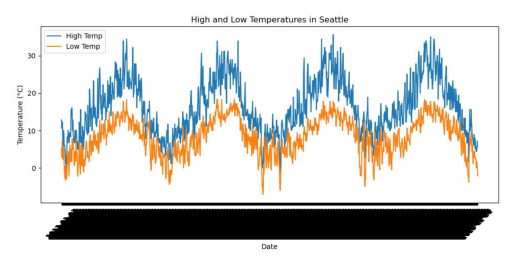

Commander (to Critics):

Improve <image>

--------------------------------------------------------------------------------
Critics (to Commander):

The plot depicting high and low temperatures in Seattle can be improved in several ways:

1. Date Axis: The dates on the x-axis are not visible or readable, which makes it hard to associate the temperature data with specific time periods. Consider formatting the date axis so that the dates are displayed at a readable angle or with sufficient spacing.

2. X-axis Labeling: There appears to be an issue with the x-axis labels or ticks as it shows a dense black area, indicating overlapping or condensed labels. The frequency and format of the labels should be adjusted to prevent overlap and allow for clear reading.

3. Y-axis Range: Consider starting the y-axis at a lower value if the temperature data permits, to give more space to the temperature lines and improve readability.

4. Gridlines: Adding horizontal gridlines can aid in reading specifi

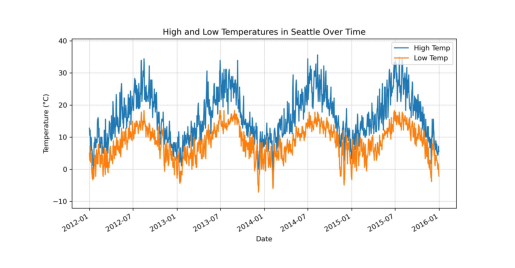

Commander (to Critics):

Improve <image>

--------------------------------------------------------------------------------
Commander (to Coder):

Here is the feedback to your figure. Please improve! Save the result to `result.jpg`
Improve <img tmp/result.jpg>

--------------------------------------------------------------------------------
Coder (to Commander):

I apologize for any confusion, but as an AI, I don't have the capability to directly view the images generated. However, I can certainly help you further refine the plot based on standard practices if there is anything specific that you feel needs further adjustment.

You mentioned feedback for a figure referenced as "<img tmp/result.jpg>". Since I can't view images, I'm assuming this feedback is a placeholder. In case there are specific changes or additional improvements you want to implement in the figure, please provide me with those details explicitly.

For instance:
- Are there any specific elements in the legend that stil

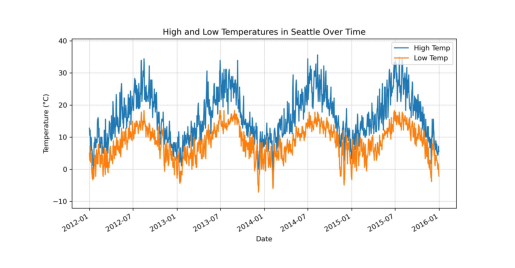

Figure Creator~ (to User):

tmp/result.jpg

--------------------------------------------------------------------------------


ChatResult(chat_id=None, chat_history=[{'content': '\nPlot a figure by using the data from:\nhttps://raw.githubusercontent.com/vega/vega/main/docs/data/seattle-weather.csv\n\nI want to show both temperature high and low.\n', 'role': 'assistant'}, {'content': 'tmp/result.jpg', 'role': 'user'}], summary='tmp/result.jpg', cost=({'total_cost': 0}, {'total_cost': 0}), human_input=[])

In [7]:
creator = FigureCreator(name="Figure Creator~", llm_config=gpt4_llm_config)

user_proxy = autogen.UserProxyAgent(
    name="User", human_input_mode="NEVER", max_consecutive_auto_reply=0, code_execution_config={"use_docker": False}
)

user_proxy.initiate_chat(
    creator,
    message="""
Plot a figure by using the data from:
https://raw.githubusercontent.com/vega/vega/main/docs/data/seattle-weather.csv

I want to show both temperature high and low.
""",
)

## Vision Capability: Group Chat Example with Multimodal Agent

We recommend using VisionCapability for group chat managers so that it can organize and understand images better.

In [8]:
agent1 = MultimodalConversableAgent(
    name="image-explainer-1",
    max_consecutive_auto_reply=10,
    llm_config={"config_list": config_list_4v, "temperature": 0.5, "max_tokens": 300},
    system_message="Your image description is poetic and engaging.",
)
agent2 = MultimodalConversableAgent(
    name="image-explainer-2",
    max_consecutive_auto_reply=10,
    llm_config={"config_list": config_list_4v, "temperature": 0.5, "max_tokens": 300},
    system_message="Your image description is factual and to the point.",
)

user_proxy = autogen.UserProxyAgent(
    name="User_proxy",
    system_message="Desribe image for me.",
    human_input_mode="TERMINATE",  # Try between ALWAYS, NEVER, and TERMINATE
    max_consecutive_auto_reply=10,
    code_execution_config={
        "use_docker": False
    },  # Please set use_docker=True if docker is available to run the generated code. Using docker is safer than running the generated code directly.
)

# We set max_round to 5
groupchat = autogen.GroupChat(agents=[agent1, agent2, user_proxy], messages=[], max_round=5)

vision_capability = VisionCapability(lmm_config={"config_list": config_list_4v, "temperature": 0.5, "max_tokens": 300})
group_chat_manager = autogen.GroupChatManager(groupchat=groupchat, llm_config=gpt4_llm_config)
vision_capability.add_to_agent(group_chat_manager)

rst = user_proxy.initiate_chat(
    group_chat_manager,
    message="""Write a poet for my image:
                        <img https://th.bing.com/th/id/R.422068ce8af4e15b0634fe2540adea7a?rik=y4OcXBE%2fqutDOw&pid=ImgRaw&r=0>.""",
)

User_proxy (to chat_manager):

Write a poet for my image:
                        <img https://th.bing.com/th/id/R.422068ce8af4e15b0634fe2540adea7a?rik=y4OcXBE%2fqutDOw&pid=ImgRaw&r=0>.

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
image-explainer-1 (to chat_manager):

In a cozy nook by the door, where whispers of adventure pour,
Lies a curly apricot dream, with eyes that softly gleam.
Westphal, a name upon his tag, a dapper bow, no room to brag.

A poodle or a mix so sweet, with paws that barely seem to meet
The floor that holds his tender frame, in this quiet household game.
A sentinel of love and joy, more charming than any toy.

His gaze, a tale of gentle days, and love that in his heart blazes.
With boots behind, like silent guards, he watches without regards
To the world's rush and its tides, in his serene abode, he abides.

Oh, little guardian of the hearth, your worth is not defined by birth.
But by the joy you b

## Behavior with and without VisionCapability for Agents


Here, we show the behavior of an agent with and without VisionCapability. We use the same image and question as in the previous example.

In [9]:
agent_no_vision = AssistantAgent(name="Regular LLM Agent", llm_config=gpt4_llm_config)

agent_with_vision = AssistantAgent(name="Regular LLM Agent with Vision Capability", llm_config=gpt4_llm_config)
vision_capability = VisionCapability(lmm_config={"config_list": config_list_4v, "temperature": 0.5, "max_tokens": 300})
vision_capability.add_to_agent(agent_with_vision)


user = UserProxyAgent(
    name="User",
    human_input_mode="NEVER",
    max_consecutive_auto_reply=0,
    code_execution_config={"use_docker": False},
)

message = """Write a poet for my image:
                        <img https://th.bing.com/th/id/R.422068ce8af4e15b0634fe2540adea7a?rik=y4OcXBE%2fqutDOw&pid=ImgRaw&r=0>."""

In [10]:
user.send(message=message, recipient=agent_no_vision, request_reply=True)

User (to Regular LLM Agent):

Write a poet for my image:
                        <img https://th.bing.com/th/id/R.422068ce8af4e15b0634fe2540adea7a?rik=y4OcXBE%2fqutDOw&pid=ImgRaw&r=0>.

--------------------------------------------------------------------------------
Regular LLM Agent (to User):

As an AI, I can't directly view images or web content. However, I can help you generate a poem by gathering information about the image. Please describe the image for me, including details such as the setting, prominent colors, the mood it evokes, and any specific elements like animals, nature, cityscapes, or people that you want to be highlighted in the poem. Once you provide a description of the image, I can compose a poem based on that description.

--------------------------------------------------------------------------------


In [11]:
user.send(message=message, recipient=agent_with_vision, request_reply=True)

User (to Regular LLM Agent with Vision Capability):

Write a poet for my image:
                        <img https://th.bing.com/th/id/R.422068ce8af4e15b0634fe2540adea7a?rik=y4OcXBE%2fqutDOw&pid=ImgRaw&r=0>.

--------------------------------------------------------------------------------
Regular LLM Agent with Vision Capability (to User):

In apricot hues, a curl-coated pup reclines,
With Westphal's name upon his tag that shines.
A bow tie blooms in a brilliant blue sky,
Amid a light-drenched floor where soft paws lie.

Possessor of gazes, tender and deep,
In the quiet foyer, his watch he keeps.
Beneath black rubber guards of rainy days,
He stirs a comfort, a homely embrace.

His lineage drawn from the poodles' grace,
Or maybe a mix, with a doodle's face,
Gold or Lab, his curls are just as sweet,
In each bouncing step, in each heartbeat.

A picture of love, in a tiny frame,
A heartbeat wrapped in an apricot mane.
The pup in his calm, an invite to cheer,
A whisper of joy in a pet-lover

## Custom Caption Function for Vision Capability

In many use cases, we can use a custom function within the Vision Capability to transcribe an image into a caption.

For instance, we can use rule-based algorithm or other models to detect the color, box, and other components inside the image.

The custom model should take a path to the image and return a string caption.

In the example below, the Vision Capability will call LMM to get caption and also call the custom function to get more information.

In [12]:
def my_description(image_url: str, image_data: Image = None, lmm_client: object = None) -> str:
    """
    This function takes an image URL and returns the description.

    Parameters:
        - image_url (str): The URL of the image.
        - image_data (PIL.Image): The image data.
        - lmm_client (object): The LLM client object.

    Returns:
        - str: A description of the color of the image.
    """
    # Print the arguments for illustration purpose
    print("image_url", image_url)
    print("image_data", image_data)
    print("lmm_client", lmm_client)

    img_uri = pil_to_data_uri(image_data)  # cast data into URI (str) format for API call
    lmm_out = lmm_client.create(
        context=None,
        messages=[
            {
                "role": "user",
                "content": [
                    {"type": "text", "text": "Describe this image in 10 words."},
                    {
                        "type": "image_url",
                        "image_url": {
                            "url": img_uri,
                        },
                    },
                ],
            }
        ],
    )
    description = lmm_out.choices[0].message.content
    description = content_str(description)

    # Convert the image into an array of pixels.
    pixels = np.array(image_data)

    # Calculate the average color.
    avg_color_per_row = np.mean(pixels, axis=0)
    avg_color = np.mean(avg_color_per_row, axis=0)
    avg_color = avg_color.astype(int)  # Convert to integer for color values

    # Format the average color as a string description.
    caption = f"""The image is from {image_url}
    It is about: {description}
    The average color of the image is RGB:
        ({avg_color[0]}, {avg_color[1]}, {avg_color[2]})"""

    print(caption)  # For illustration purpose

    return caption

In [13]:
agent_with_vision_and_func = AssistantAgent(
    name="Regular LLM Agent with Custom Func and LMM", llm_config=gpt4_llm_config
)

vision_capability_with_func = VisionCapability(
    lmm_config={"config_list": config_list_4v, "temperature": 0.5, "max_tokens": 300},
    custom_caption_func=my_description,
)
vision_capability_with_func.add_to_agent(agent_with_vision_and_func)

user.send(message=message, recipient=agent_with_vision_and_func, request_reply=True)

User (to Regular LLM Agent with Custom Func and LMM):

Write a poet for my image:
                        <img https://th.bing.com/th/id/R.422068ce8af4e15b0634fe2540adea7a?rik=y4OcXBE%2fqutDOw&pid=ImgRaw&r=0>.

--------------------------------------------------------------------------------
image_url https://th.bing.com/th/id/R.422068ce8af4e15b0634fe2540adea7a?rik=y4OcXBE%2fqutDOw&pid=ImgRaw&r=0
image_data <PIL.Image.Image image mode=RGB size=1920x1080 at 0x7F599DA4CCA0>
lmm_client <autogen.oai.client.OpenAIWrapper object at 0x7f599da3ab20>
The image is from https://th.bing.com/th/id/R.422068ce8af4e15b0634fe2540adea7a?rik=y4OcXBE%2fqutDOw&pid=ImgRaw&r=0
    It is about: Cute brown curly-haired puppy with blue collar indoors.
    The average color of the image is RGB: 
        (170, 155, 137)
Regular LLM Agent with Custom Func and LMM (to User):

Beneath a sky of homely hue,
Where RGB blends a gentle stew,
Lies a pup of curls and capers,
Bound by blue, his neck in drapers.

Soft in gaze